# INITIAL REMARKS :

This script and all the analyses performed in this project aim to show possible approaches to a forecasting case study.
In the following lines of code, several models, techniques and ideas have been proposed.
Not all the proposed models are necessarily the best option or the best idea for this specific task, the reason why I proposed them is to provide an interesting approach to the analysis, also many other options could be explored but only a few examples have been proposed (the tools and techniques of machine learning and data science are so many that it would take a long time to present them all)
I hope that the readers will find my work useful!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as st
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Model

In [2]:
# get the directory

base_dir='/kaggle/input/rohlik-sales-forecasting-challenge-v2'
train_path=os.path.join(base_dir,'sales_train.csv')
test_path=os.path.join(base_dir,'sales_test.csv')
inventori_path='/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv'
calendar_path='/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv'

In [3]:
#upload datasets
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
inventory=pd.read_csv(inventori_path)
calendar=pd.read_csv(calendar_path)

In [4]:
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [5]:
train=train.drop_duplicates()

In [6]:
#if the 'sales discount' is <0 means that there is no disc.
# set the this values == 0

def fix_discount(discount):
    discount=np.where(discount<0,0,discount)
    return discount


train['type_0_discount']=fix_discount(train['type_0_discount'])
train['type_1_discount']=fix_discount(train['type_1_discount'])
train['type_2_discount']=fix_discount(train['type_2_discount'])
train['type_3_discount']=fix_discount(train['type_3_discount'])
train['type_4_discount']=fix_discount(train['type_4_discount'])
train['type_5_discount']=fix_discount(train['type_5_discount'])
train['type_6_discount']=fix_discount(train['type_6_discount'])

In [7]:
# remove na from sales column
train=train.dropna(subset=['sales'])


#split the date in : day, month, year
train[['year','month','day']]=train['date'].str.split('-',expand=True)




In [8]:
train=train.merge(calendar,on=['date','warehouse'],how='left')
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,type_5_discount,type_6_discount,year,month,day,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,0.0,0.0,2024,03,10,NaN,0,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,2021,05,25,NaN,0,0,0,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,0.0,0.0,2021,12,20,NaN,0,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,0.0,0.0,2023,04,29,NaN,0,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,0.0,0.0,2022,04,01,NaN,0,0,0,0


In [9]:
train=train.drop(columns=['date'])

# EDA ; merging ; cleaning

First of all I start with looking at the sales evolution over time.
The time horizon available include also 2020 : COVID--> I expect a lower sales volume in that year, it might be a suitable solution to remove this year from the analysis as it could be considered as it is a "break" in the considered scenario.

In [10]:
def trend_plot(train, timepoint, group='warehouse', sales='sales'):
    
    warehouse=train[group].sample(4)

    fig,axis =plt.subplots(2,2,figsize=(20,20))
    
    
    
    df_plot1=train[train[group]==warehouse.iloc[0]]
    df_plot1=df_plot1.groupby([timepoint])[sales].sum().reset_index()
    axis[0,0].plot(df_plot1[timepoint],df_plot1[sales],marker='o',linestyle='-')
    axis[0,0].set_title(f"{warehouse.iloc[0]}")
    
    df_plot2=train[train[group]==warehouse.iloc[1]]
    df_plot2=df_plot2.groupby([timepoint])[sales].sum().reset_index()
    axis[0,1].plot(df_plot2[timepoint],df_plot2[sales],marker='o',linestyle='-')
    axis[0,1].set_title(f"{warehouse.iloc[1]}")
    
    
    df_plot3=train[train[group]==warehouse.iloc[2]]
    df_plot3=df_plot3.groupby([timepoint])[sales].sum().reset_index()
    axis[1,0].plot(df_plot3[timepoint],df_plot3[sales],marker='o',linestyle='-')
    axis[1,0].set_title(f"{warehouse.iloc[2]}")
    
    
    df_plot4=train[train[group]==warehouse.iloc[3]]
    df_plot4=df_plot4.groupby([timepoint])[sales].sum().reset_index()
    axis[1,1].plot(df_plot4[timepoint],df_plot4[sales],marker='o',linestyle='-')
    axis[1,1].set_title(f"{warehouse.iloc[3]}")
    
    
    
    plt.show()


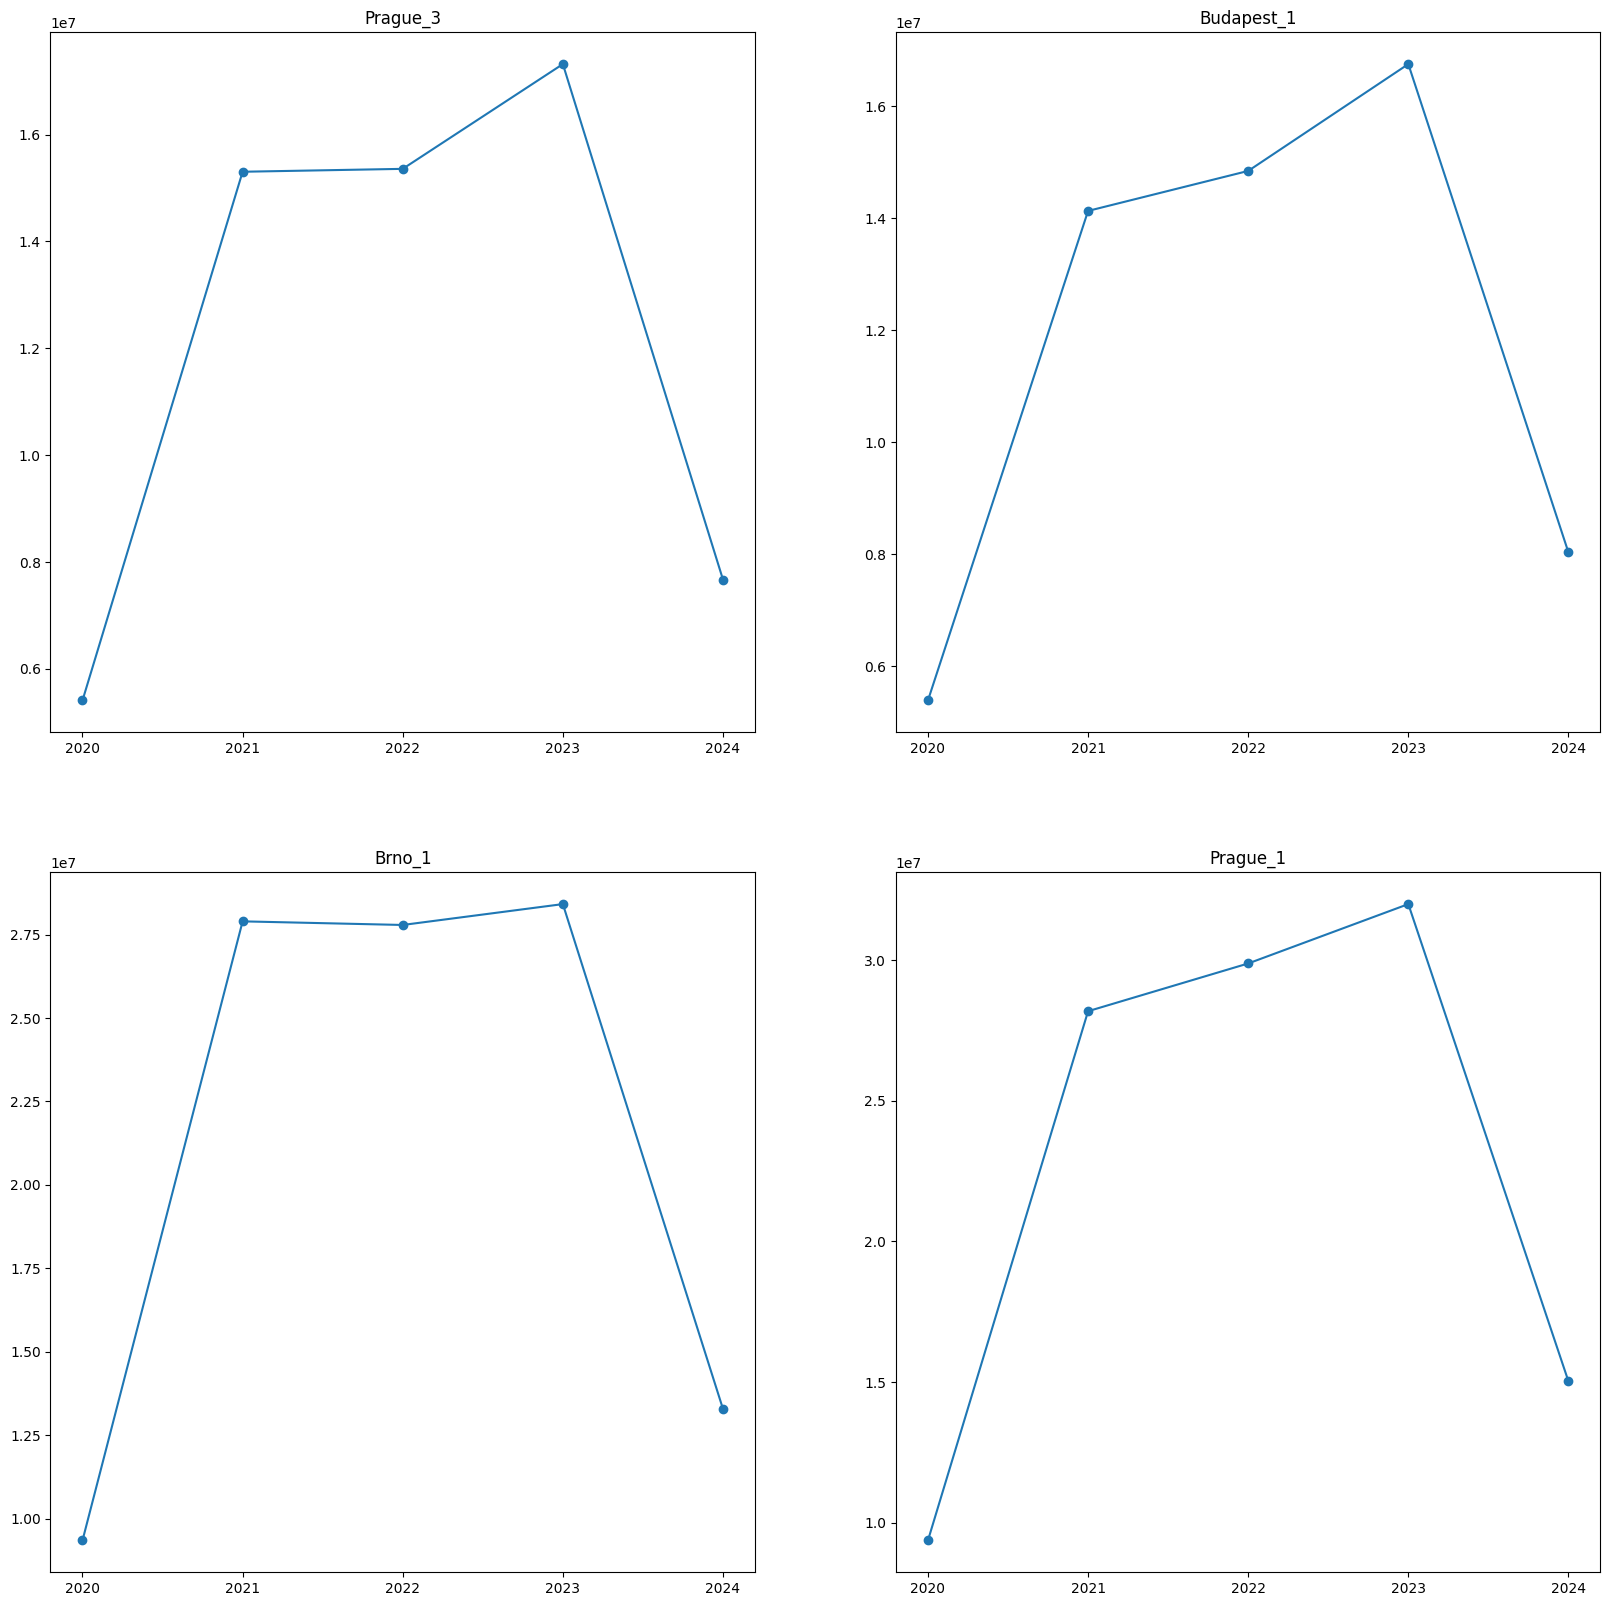

In [11]:
trend_plot(train,timepoint='year')

As said before there is a problem related to an extornal uncontrolled phenomena as COVID19.
Moreover it is possible to see that there is an anomalous drop in 2024 which is contrasting the growing trend from 2021 to 2023. This is due to the data availability, indeed we have data only up to June-2024.

It may be a suitable solution to drop both years and proceed with the analysis.

POSSIBLE SECONDARY APPROACH :
thanks to kalman filter it is possible to predict the next sales value based on the previous observation, after using this method to retrieve possible value up to the end of 2024 proceed with other method for sales prediction
POSSIBLE DRAWBACK: I am increasing variability at each step, this means that we sacrify reliabilty of data

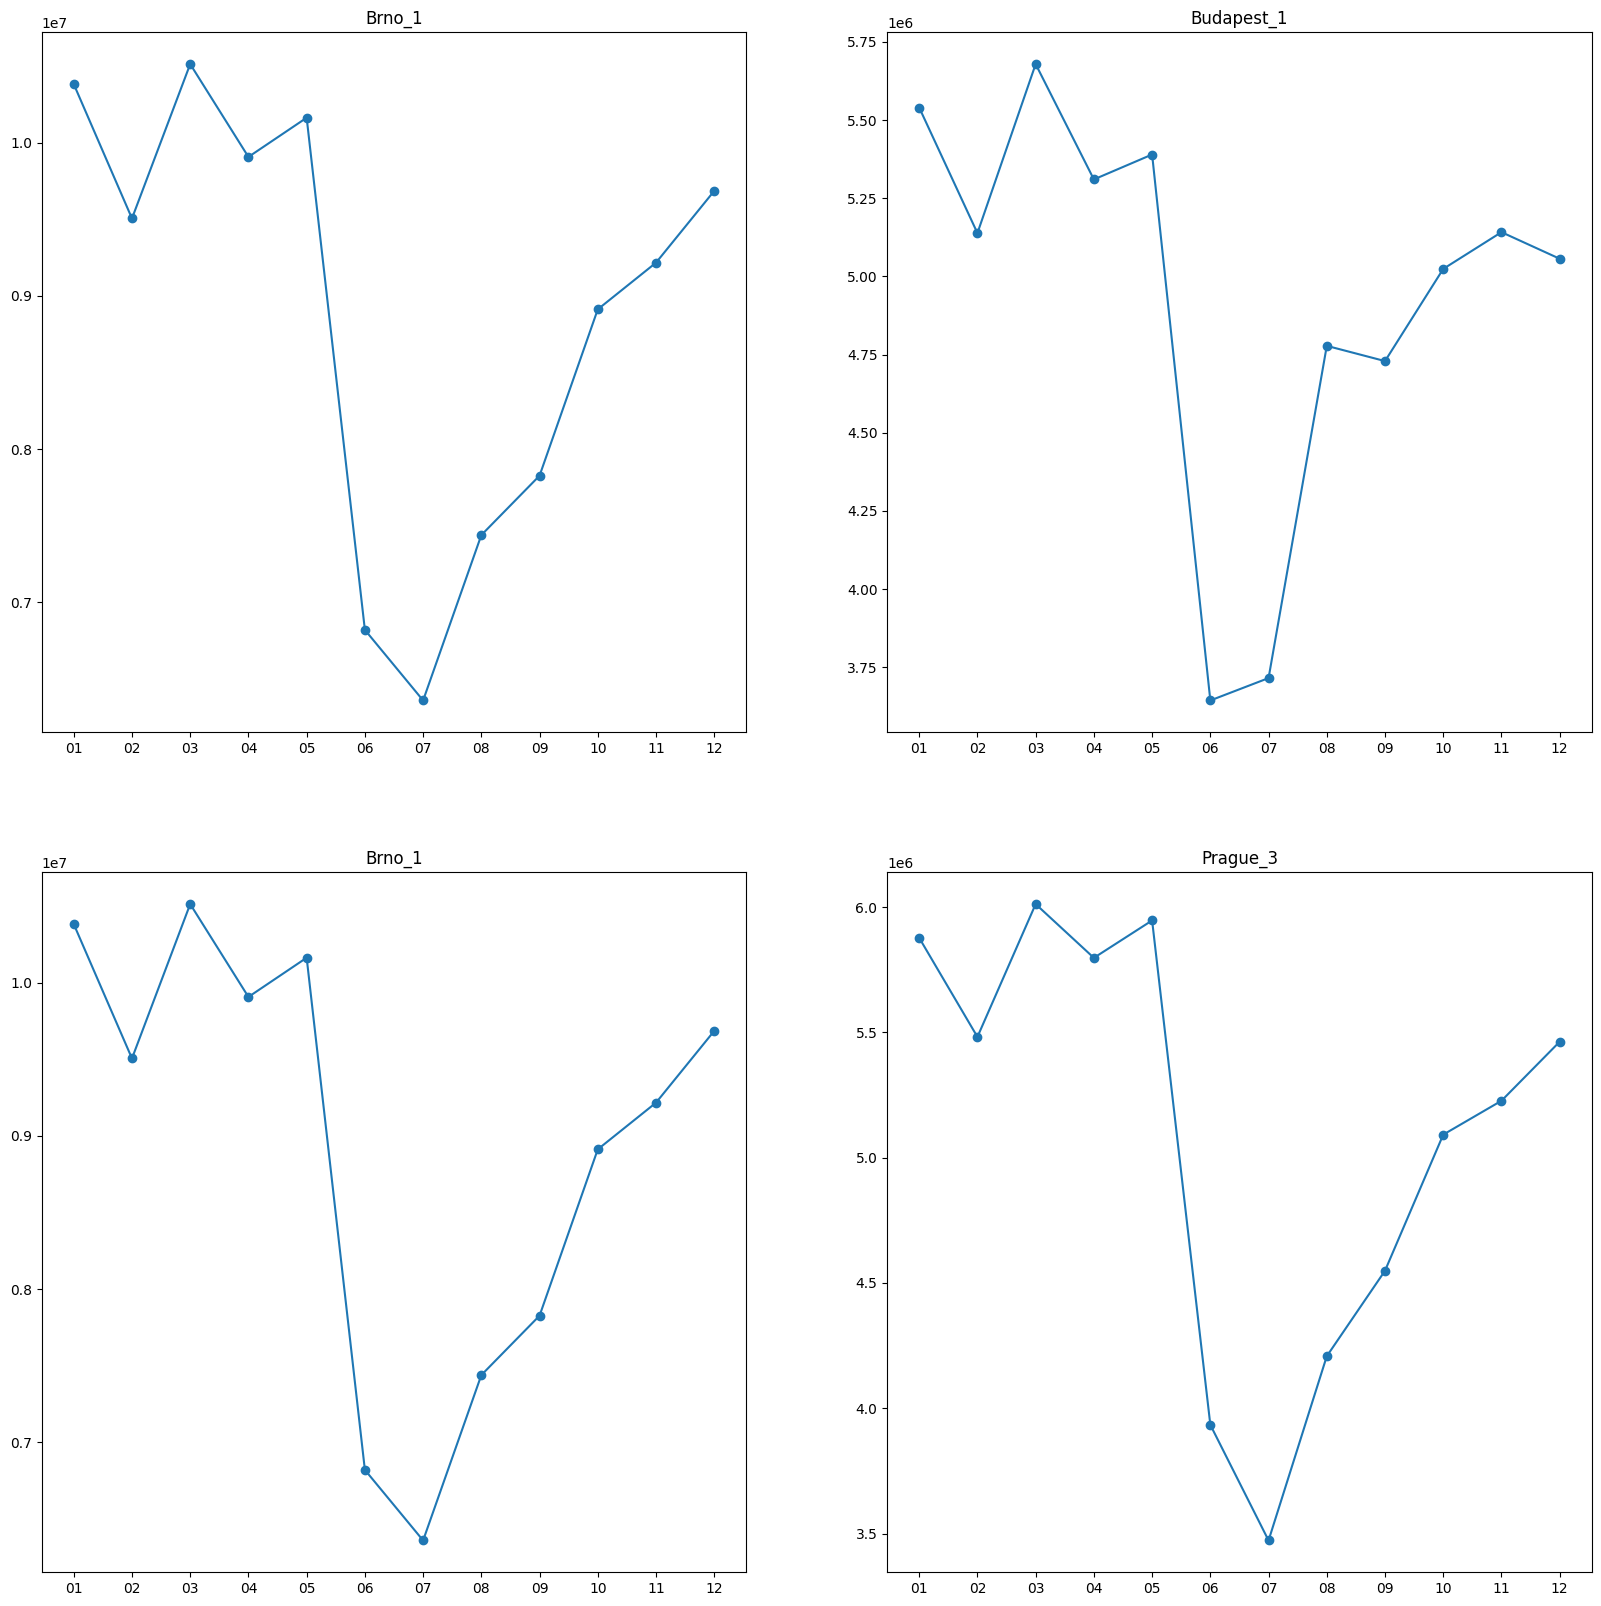

In [12]:
trend_plot(train,timepoint='month')

In [13]:
#train = train[train['sales'] != 0]
train = train[train['year'] != 2020]

<function matplotlib.pyplot.show(close=None, block=None)>

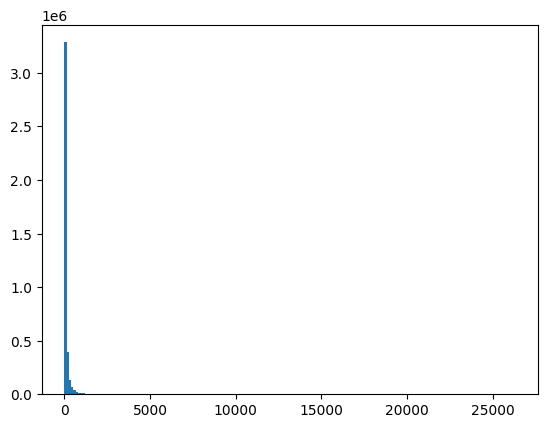

In [14]:
# now let's look at sales distribution
plt.hist(train['sales'],bins=200)
plt.show#there are a lot of zeros and the values are strongly right skewed

In [15]:
train['sales'][train['sales']==0].count()

49207

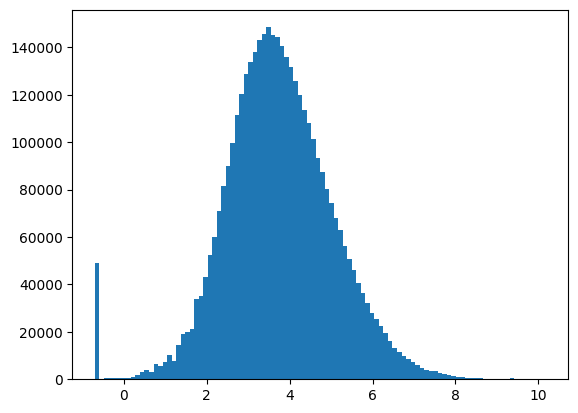

In [16]:
plt.hist(np.log(train['sales']+0.5),bins=100)
plt.show()

By applying the log transformation to the sales it is possible to shape their distribution as a normal-like distribution(clearly not a perfect normal but still good enought to help possible algorithms). We can also see a problem related to the zero-sales. Having no further information those value may be or not anomalies and negatively influence the results reliability.

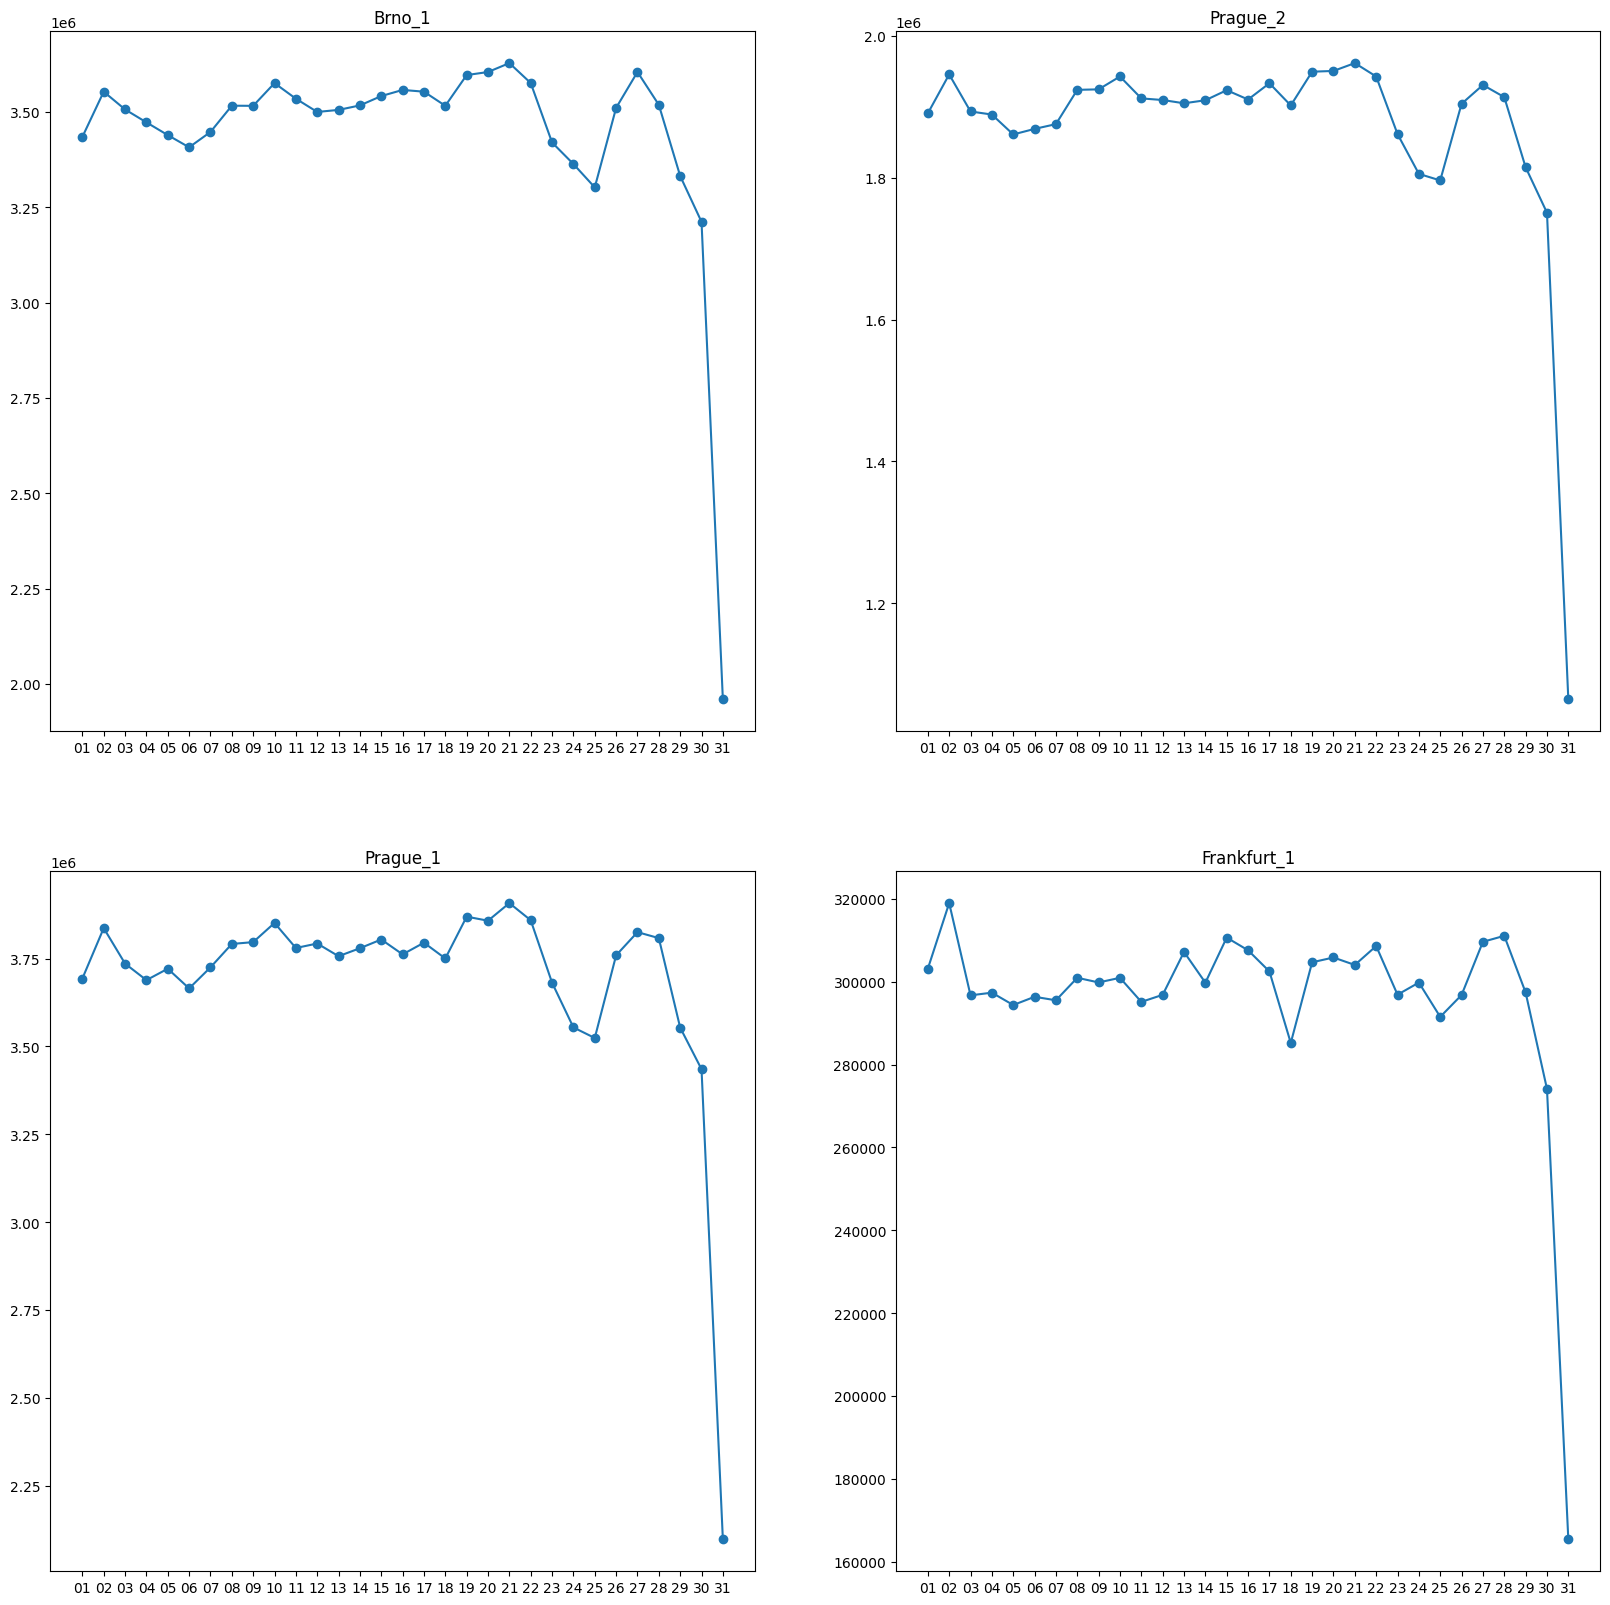

In [17]:
trend_plot(train,timepoint='day')

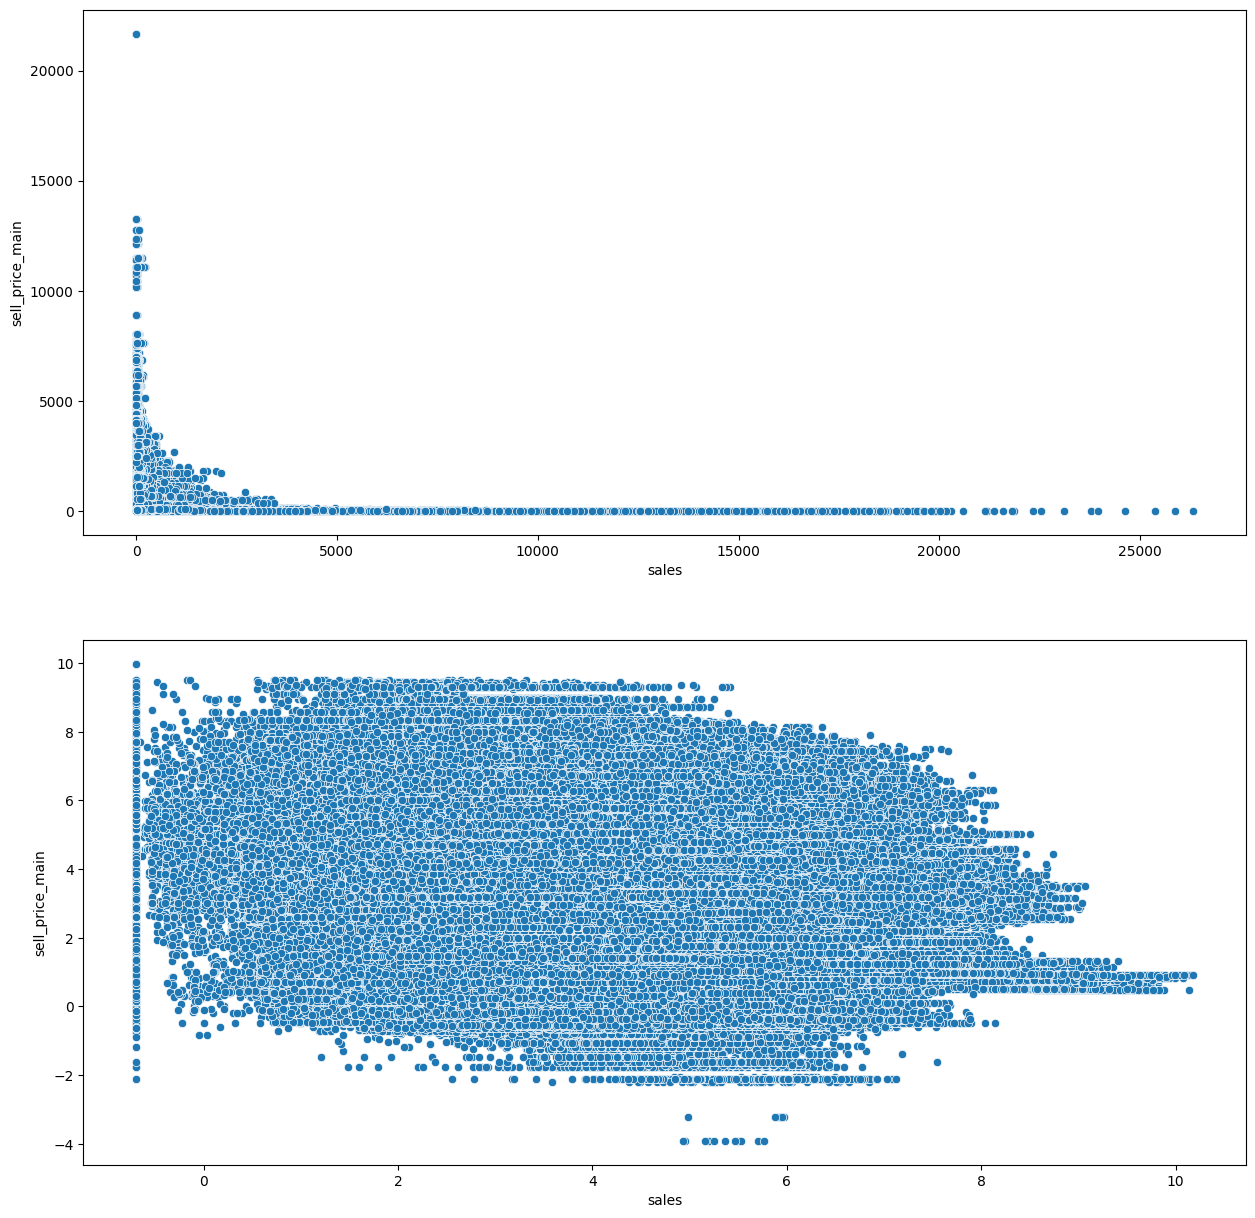

In [18]:
fig,axis=plt.subplots(2,1,figsize=(15,15))
sns.scatterplot(x=train['sales'],y=train['sell_price_main'],ax=axis[0])
sns.scatterplot(x=np.log(train['sales']+0.5),y=np.log(train['sell_price_main']),ax=axis[1])
plt.show()

No log-transformation : low price--> higher sales ; high price-->lower sales

Yes log-transormation : no clear trend between the variable


NOTE: These graphs do not consider the variability of price within the product. This means that relationships like low price == high sales may not be related to price elasticity, but instead could suggest the existence of three categories (clusters) of product such as: low margin - medium margin - high margin and clearly the lower the margin the higher the breakeven required, hence the higher the overall sales

This observation aims to outline the importance of understanding the context and how different considerations can lead to completely different managerial decisions. Since the goal of this project is prediction and not interpretability, I will not go into detail and focus only on error reduction, but even considering this, the above observation could help to develop additional variables (e.g. cluster labels) that could improve performance

ADDITIONAL NOTE: From the above graphs we can see some values ​​that could be considered anomalies or outliers, for example there is a value with a really extremely high price (no transformation) or small localized clusters (with transformation)

In [19]:
train=train[train['sales']!=0]

In [20]:
dropped_columns=['winter_school_holidays','school_holidays']
train=train.drop(columns=dropped_columns)
train.columns

Index(['unique_id', 'warehouse', 'total_orders', 'sales', 'sell_price_main',
       'availability', 'type_0_discount', 'type_1_discount', 'type_2_discount',
       'type_3_discount', 'type_4_discount', 'type_5_discount',
       'type_6_discount', 'year', 'month', 'day', 'holiday_name', 'holiday',
       'shops_closed'],
      dtype='object')

In [21]:
#only the highest discount is used for sales--> instead of using one column for each disc, just use only the applied discount
multiple_discount=['type_0_discount', 'type_1_discount', 'type_2_discount',
       'type_3_discount', 'type_4_discount', 'type_5_discount',
       'type_6_discount']


train['discount']=train[multiple_discount].max(axis=1)
train['discount'].head()

0    0.15312
1    0.15025
2    0.15025
3    0.20024
4    0.15649
Name: discount, dtype: float64

In [22]:
train=train.drop(columns=multiple_discount)

In [23]:
train=train.merge(inventory,on=['unique_id','warehouse'],how='left')

In [24]:
train['holiday_name']=train['holiday_name'].fillna('No_holiday')
train.isna().any()

unique_id              False
warehouse              False
total_orders           False
sales                  False
sell_price_main        False
availability           False
year                   False
month                  False
day                    False
holiday_name           False
holiday                False
shops_closed           False
discount               False
product_unique_id      False
name                   False
L1_category_name_en    False
L2_category_name_en    False
L3_category_name_en    False
L4_category_name_en    False
dtype: bool

In [25]:
#in order to avoid over complexity I decide to rely only on the more general category description
category_detail=['L2_category_name_en','L3_category_name_en','L4_category_name_en']
train=train.drop(columns=category_detail)
train.columns

Index(['unique_id', 'warehouse', 'total_orders', 'sales', 'sell_price_main',
       'availability', 'year', 'month', 'day', 'holiday_name', 'holiday',
       'shops_closed', 'discount', 'product_unique_id', 'name',
       'L1_category_name_en'],
      dtype='object')

In [26]:
#now that we have all the variable let's encode the categorical
encoder=LabelEncoder()
category=['L1_category_name_en','name','holiday_name','day','month','year','warehouse']
for col in category:
    train[col]=encoder.fit_transform(train[col])
    

train.head()

,unique_id,warehouse,total_orders,sales,sell_price_main,availability,year,month,day,holiday_name,holiday,shops_closed,discount,product_unique_id,name,L1_category_name_en
0,4845,1,6436.0,16.34,646.26,1.00,4,2,9,31,0,0,0.15312,2375,959,0
1,4845,1,4663.0,12.63,455.96,1.00,1,4,24,31,0,0,0.15025,2375,959,0
2,4845,1,6507.0,34.55,455.96,1.00,1,11,19,31,0,0,0.15025,2375,959,0
3,4845,1,5463.0,34.52,646.26,0.96,3,3,28,31,0,0,0.20024,2375,959,0
4,4845,1,5997.0,35.92,486.41,1.00,2,3,0,31,0,0,0.15649,2375,959,0


# Start of the analysis

In [27]:
# split in train and validation

x=train.drop(columns=['sales'])
y=train['sales']
print(x.shape , y.shape)
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.3,random_state=42)

(3958160, 15) (3958160,)


In [28]:
#Function that allow to directly implement and valuate a model

def model_implementation(x_train,y_train,x_val,y_val,parameters,model):
    grid_search=GridSearchCV(estimator=model,param_grid=parameters,cv=3)
    grid_search=grid_search.fit(x_train,y_train)
    print(f"Best params : {grid_search.best_params_} ; Best score : {grid_search.best_score_}")
    print(f"\n R2 : {grid_search.score(x_val,y_val)}")
    MSE_train=metrics.mean_squared_error(y_train,grid_search.predict(x_train))
    MSE_val=metrics.mean_squared_error(y_val,grid_search.predict(x_val))
    R2_train=metrics.r2_score(y_train,grid_search.predict(x_train))
    R2_val=metrics.r2_score(y_val,grid_search.predict(x_val))
    print(f"\n train :\n MSE {MSE_train} ; \nR2 {R2_train} ; \n test : \nMSE {MSE_val} ; \nR2 {R2_val}")
    return grid_search.best_estimator_

# XGB

In [29]:
model_xgb = xgb.XGBRegressor()


parameters = {
    'objective': ['reg:squarederror'],
    'n_estimators': [50, 100, 200],  
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.2, 0.5],
    'eval_metric': ['error'],  
    'gamma': [0.1, 0.3, 0.5],
      
}

In [30]:

#xgb=model_implementation(x_train,y_train,x_val,y_val,parameters,model_xgb)
#xgb


Best params : {'eval_metric': 'error', 'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'} ; Best score : 0.9565499877791751

R2 : 0.9561076620090418

train : MSE 4613.997615713352 ; R2 0.9644785744462597 ; test : MSE 5907.978941655915 ; R2 0.9561076620090418

In [31]:


y_train_log=y_train.copy()
x_train_log=x_train.copy()
x_train_log['sell_price_main']=np.log(x_train_log['sell_price_main']+0.5)
y_train_log=np.log(y_train_log+0.5)

x_val_log=x_val.copy()
x_val_log['sell_price_main']=np.log(x_val_log['sell_price_main']+0.5)
y_val_log=y_val.copy()
y_val_log=np.log(y_val_log+0.5)


#model_implementation(x_train_log,y_train_log,x_val_log,y_val_log,parameters,model_xgb)



Best params : {'eval_metric': 'error', 'gamma': 0.3, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 200, 'objective': 'reg:squarederror'} ; Best score : 0.8398016361144597

R2 : 0.8403017839678054

train : MSE 0.238940071886664 ; R2 0.8427676985836671 ; test : MSE 0.24307858790297063 ; R2 0.8403017839678054

# DENSE NETWORK

In [32]:
def simple_dense(x_train,y_train,x_val,y_val):
    
    model=tf.keras.models.Sequential()

    model.add(layers.Dense(64,input_shape=(x_train.shape[1],),activation='relu'))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dense(1))
    model.summary()

    model.compile(loss='mean_squared_error',optimizer='adam')
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
    model.fit(x_train,y_train,epochs=20,batch_size=32,verbose=1,callbacks=callbacks)
    score=model.evaluate(x_val,y_val,verbose=1)
    print("Validation loss:", score)

In [33]:
#simple_dense(x_train,y_train,x_val,y_val)

Validation loss: 57283.203125

In [34]:
def medium_dense(x_train,y_train,x_val,y_val,epochs,batch):
    model=tf.keras.models.Sequential()

    model.add(layers.Dense(64,input_shape=(x_train.shape[1],),activation='relu'))
    #model.add(layers.Dense(64,activation='relu'))
    #model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(32,activation='relu'))
    #model.add(layers.Dense(32,activation='relu'))
    
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dense(16,activation='relu'))
    
    #model.add(layers.Dense(8,activation='relu'))
    #model.add(layers.Dense(8,activation='relu'))

    model.add(layers.Dense(1))

    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=[tf.metrics.RootMeanSquaredError(),
                                                                      tf.metrics.MeanAbsoluteError()])
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs')]
    
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch,callbacks=callbacks)
    score=model.evaluate(x_val,y_val,verbose=1)
    y_pred=model.predict(x_val)
    r2=r2_score(y_val,y_pred)
    print("Validation R²:", r2)
    print("Validation loss (MSE):", score[0])
    print("Validation RMSE:", score[1])
    print("Validation MAE:", score[2])
    return model

In [35]:
EPOCHS=50
BATCH=64
#medium_nn=medium_dense(x_train,y_train,x_val,y_val,epochs=EPOCHS,batch=BATCH)
#medium_nn

After a trial-and-error approach to identify possible improvements to the neural network, I can conclude that on average the data for this context prefers a simpler NN over a more complex and structured one. On top of that, xgb is still performing much better

# KNN regressor

The idea behind this implementation choice is that we want to understand if the neighborhood of the covariates of a value is able to correctly identify the target value. This means that we want to understand if there is something that can be considered as a local clustering factor that can determine the final output: close values in the covariates lead to similar values in the target.

Considering that knn is highly sensitive to the way the distance is calculated and also to the data structure, I decided to implement a begging approach by selecting several possible subsets of covariates to use for the regression. The reason for this choice is that a high dimensionality can increase the overall distance between two points by reducing the "relevance" of the neighborhood

Due to the high computational cost for knn with large datasets, to address this problem I decided to use a bagging strategy by selecting at each iteration a strongly reduced number of the available observations. Having more time and resources available, one could test the performance by exploiting a larger sampling

In [36]:
scaler = StandardScaler(copy=False)  
scaler.fit(x_train) 

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)
x_val_scaled = pd.DataFrame(x_val_scaled, index=x_val.index, columns=x_val.columns)


In [37]:


def multiple_knn(x_train, y_train, x_val, y_val, parameters, max_iteration):
    base_knn = KNeighborsRegressor()
    print(f"Inizializzazione BaggingRegressor...")
    
    bagging_knn = BaggingRegressor(
        estimator=base_knn, 
        bootstrap_features=True,
        bootstrap=True,
        n_jobs=-1
    )

    print(f"Eseguendo Grid Search...")
    grid_search = GridSearchCV(bagging_knn, param_grid=parameters, cv=3, verbose=1)
    grid_search.fit(x_train, y_train) 

    print(f"Best params: {grid_search.best_params_} ; Best score: {grid_search.best_score_}")

    scores = []
    mse_vals = []

    for iteration in range(max_iteration):
        print(f"Iteration: {iteration+1}/{max_iteration}")
        sample_index = x_val.sample(frac=0.025).index
        x_val_sample = x_val.loc[sample_index]
        y_val_sample = y_val.loc[sample_index]

        scores.append(grid_search.score(x_val_sample, y_val_sample))
        mse_vals.append(metrics.mean_squared_error(y_val_sample, grid_search.predict(x_val_sample)))

    final_score = np.mean(scores)
    final_mse = np.mean(mse_vals)
    print(f"Final R2: {final_score}\nFinal MSE: {final_mse}")

    return grid_search.best_estimator_






parameters = {
    'estimator__n_neighbors': [5], 
    'n_estimators': [40],
    'estimator__weights': ['distance'],
    'max_samples': [0.025]
}




#model_knn = multiple_knn(x_train_scaled, y_train, x_val_scaled, y_val, parameters, max_iteration=10)


Best params: {'estimator__n_neighbors': 5, 'estimator__weights': 'distance', 'max_samples': 0.025, 'n_estimators': 40} ; Best score: 0.27298208496634063


Final R2: 0.2509235655876286
Final MSE: 102214.99040046075

As expected we have low performances compared to the others

# DENSE_NN+XGB

Now I try to mix the results of the dense nn and xgb, which means that now I want to use a dense nn, starting from the previously created simple dense, and use it as a pre-processing tool to extract the relevant features from the data (the output of the final layer nodes) and use it in xgboost

In [38]:
def simple_dense_v2(x_train, y_train, x_val, y_val):
    # Input layer
    inputs = layers.Input(shape=(x_train.shape[1],))

    # Hidden layers
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    xgb_input = layers.Dense(16, activation='relu', name='xgb_input')(x)
    output = layers.Dense(1)(xgb_input)  # Output layer

    # build the model
    model = Model(inputs=inputs, outputs=output)

    
    model.summary()

    # compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    # train
    model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)
    
    # force the model initialization
    _ = model.predict(x_train[:1]) 

    # get the intermediate layer
    xgb_input_layer = Model(inputs=model.input, outputs=model.get_layer('xgb_input').output)

    # evaluation
    score = model.evaluate(x_val, y_val, verbose=1)
    print("Validation loss:", score)

    # get the output of the intermediate layer
    xgb_input = xgb_input_layer.predict(x_train)
    xgb_input_val = xgb_input_layer.predict(x_val)

    
    return xgb_input,xgb_input_val



In [39]:
#xgb_input,xgb_input_val=simple_dense_v2(x_train,y_train,x_val,y_val)

Epoch 20/20 86585/86585 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - loss: 52824.0977 1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step 37108/37108 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - loss: 46614.1758 Validation loss: 46854.7421875

In [40]:

xgb_model=xgb.XGBRegressor()
parameters={
    'objective':['reg:squarederror'],
    'n_estimators':[300,500,1000],
    'learning_rate':[0.5,0.6,0.7],
    'eval_metric': ['error'],
    'gamma':[0.001,0.01,0.05] 
}
#xgb_densenn_model=model_implementation(xgb_input,y_train,xgb_input_val,y_val,parameters,xgb_densenn)

Best params : {'eval_metric': 'error', 'gamma': 0.001, 'learning_rate': 0.5, 'n_estimators': 1000, 'objective': 'reg:squarederror'} ; Best score : 0.7774880404842519

R2 : 0.7881326072423618

train : MSE 21349.492027151264 ; R2 0.8356383217299568 ; test : MSE 28517.69015114946 ; R2 0.7881326072423618

Even though the overall mse is lower than a dense nn, the final result is still much worse than a standard xgb.

For this reason I decided to conclude the analysis by adjusting the parameters of the xgb model.

In [41]:
parameters={
    'objective':['reg:squarederror'],
    'n_estimators':[800,1000],
    'learning_rate':[0.4,0.5],
    'eval_metric': ['error'],
    'gamma':[0.001] 
}
#xgb_model2=model_implementation(x_train,y_train,x_val,y_val,parameters,xgb_model)

Best params : {'eval_metric': 'error', 'gamma': 0.001, 'learning_rate': 0.4, 'n_estimators': 1000, 'objective': 'reg:squarederror'} ; Best score : 0.9685390511029635

 R2 : 0.9700304459219002

 train :
 MSE 2379.8666321978226 ; 
R2 0.9816783053559563 ; 
 test : 
MSE 4033.9499440814975 ; 
R2 0.9700304459219002

# Results analysis and final considerations

In [42]:
x_val['sell_price_main'].min(), x_val['sell_price_main'].max(),y_val.mean(),y_val.mode(),y_val.max(),y_val.min()


(0.02,
 13252.94,
 110.22152543100836,
 0    10.82
 1    14.77
 Name: sales, dtype: float64,
 24626.66,
 0.03)

0.02,

 13252.94,
 
 110.22152543100836,
 
 mean   10.82
 
 mode   14.77
 
 
 max    24626.66,
 
 min    0.03

Sales and price values are EXTREMELY variable, this means that an error of about 60 unit of sales is not necessarely a good or bad result, we need to contextualize it and go more in detail!!!

In [43]:
y_val_lowsales = y_val.loc[y_val <= 10]
x_val_lowsales = x_val.loc[y_val_lowsales.index]

y_val_mediumsales = y_val.loc[(y_val > 10) & (y_val < 100)]
x_val_mediumsales = x_val.loc[y_val_mediumsales.index]

y_val_medium_highsales = y_val.loc[(y_val >= 100) & (y_val < 1000)]
x_val_medium_highsales = x_val.loc[y_val_medium_highsales.index]  # Corretto!

y_val_highsales = y_val.loc[(y_val >= 1000) & (y_val < 4000)]
x_val_highsales = x_val.loc[y_val_highsales.index]

y_val_superhighsales = y_val.loc[(y_val >= 4000) & (y_val < 10000)]
x_val_superhighsales = x_val.loc[y_val_superhighsales.index]

y_val_extreme = y_val.loc[y_val >= 10000]
x_val_extreme = x_val.loc[y_val_extreme.index]

In [44]:

MSE_low = metrics.mean_squared_error(y_val_lowsales, xgb_model2.predict(x_val_lowsales), squared=False)
MSE_medium = metrics.mean_squared_error(y_val_mediumsales, xgb_model2.predict(x_val_mediumsales), squared=False)
MSE_mediumhigh = metrics.mean_squared_error(y_val_medium_highsales, xgb_model2.predict(x_val_medium_highsales), squared=False)
MSE_high = metrics.mean_squared_error(y_val_highsales, xgb_model2.predict(x_val_highsales), squared=False)
MSE_superhigh = metrics.mean_squared_error(y_val_superhighsales, xgb_model2.predict(x_val_superhighsales), squared=False)
MSE_extreme = metrics.mean_squared_error(y_val_extreme, xgb_model2.predict(x_val_extreme), squared=False)
print(f"MSE_low :{MSE_low}\n MSE_medium : {MSE_medium}\n MSE_high : {MSE_high}\n MSE_mediumhigh : {MSE_mediumhigh}\nMSE_superhigh : {MSE_superhigh}\nMSE_extreme :{MSE_extreme}")

NameError: name 'xgb_model2' is not defined

MSE_low :36.5042570240523

 MSE_medium : 25.653363097204657
 
 MSE_high : 304.6373496503325
 
 MSE_mediumhigh : 76.2157853007747
 
MSE_superhigh : 765.5705004874789

MSE_extreme :1446.4834256880717

 FINAL COMMENT
as we can see there is a lot of variability for the error term
even if some values could be acceptable it is necessary to go into even more detail in the metric evaluation.
From the result we can see that some error terms are clearly not acceptable for example MSE_low is calculated starting from <1 sales (which we do not know if they are acceptable values or not as they could be measured in kg and not in units) but an error of about 37, this means that on average for low sales we predict much more than the real value.
on the other hand for higher values this problem seems to be partially flattened but a more in-depth (and probably time-consuming) analysis should be necessary

This comment is to show how the original output is useless if you do not pay attention to understand its meaning

# Possible development 

As just shown above, it is necessary to take into account the extreme variability of sales. To address this problem, a possible approach could be to identify significant clusters and perform different analyses for each of them (for example, clusters of records based on price-sales or product-price relationships).

If this is not enough, it may be necessary to have more information about the acceptable range of sales to understand how to behave with respect to those extreme values.